# Regression analysis

This notebook demnstrates the regression analysis on

- credibleSetSize
- MAF
- beta
- sampleSize

The analysis is performed using random effect model and fixed effect model.

Since this is a meta analysis betwen the different datasets, we need to be sure that we do not invalidate the independence assumption of the regression model, hence we use the `studyType` as a random effect covariate.


## Data Loading

The goal of this notebook is to check the distribution of study types in the dataset.


In [ ]:
from itertools import combinations

import plotnine as p9
from gentropy.common.session import Session
from pyspark.sql import functions as f
from statsmodels.formula.api import mixedlm, poisson

from manuscript_methods import OpenTargetsTheme
from manuscript_methods.datasets import LeadVariantEffect
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead_variant_effect"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 15:07:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 15:08:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 15:08:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/07/03 15:08:00 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/07/03 15:08:00 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select(
    f.abs("rescaledStatistics.estimatedBeta").alias("absEstimatedBeta"),
    "studyStatistics.studyType",
    f.col("majorLdPopulationMaf").getField("value").alias("MAF"),
    "locusStatistics.locusSize",
    "studyStatistics.nSamples",
)
data = dataset.toPandas()


## credible set size vs MAF

Regression according to the model:


In [5]:
clean_data = data.dropna(subset=["MAF", "locusSize", "absEstimatedBeta", "nSamples"]).reset_index(drop=True)


In [ ]:
subset = ["MAF", "locusSize", "absEstimatedBeta", "nSamples"]
formulas = [f"{v[0]} ~ {v[1]}" for v in combinations(subset, 2)]
models = []
for form in formulas:
    if "locusSize" in form or "nSamples" in form:
    else:
        model = smf.glm(form, )
for idx, v in enumerate(models):
    print(v, formulas[idx])


<statsmodels.discrete.discrete_model.Poisson object at 0x177996450> MAF ~ locusSize
<statsmodels.regression.mixed_linear_model.MixedLM object at 0x17797f190> MAF ~ absEstimatedBeta
<statsmodels.discrete.discrete_model.Poisson object at 0x177ba8450> MAF ~ nSamples
<statsmodels.discrete.discrete_model.Poisson object at 0x177b74250> locusSize ~ absEstimatedBeta
<statsmodels.discrete.discrete_model.Poisson object at 0x177a3be90> locusSize ~ nSamples
<statsmodels.discrete.discrete_model.Poisson object at 0x1779450d0> absEstimatedBeta ~ nSamples


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: MAF         
No. Observations: 2820468  Method:             REML        
No. Groups:       7        Scale:              0.0230      
Min. group size:  15933    Log-Likelihood:     1316142.2608
Max. group size:  1348868  Converged:          Yes         
Mean group size:  402924.0                                 
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.226     0.057   3.940  0.000   0.114   0.338
locusSize     0.000     0.000  52.491  0.000   0.000   0.000
Group Var     0.023                                         



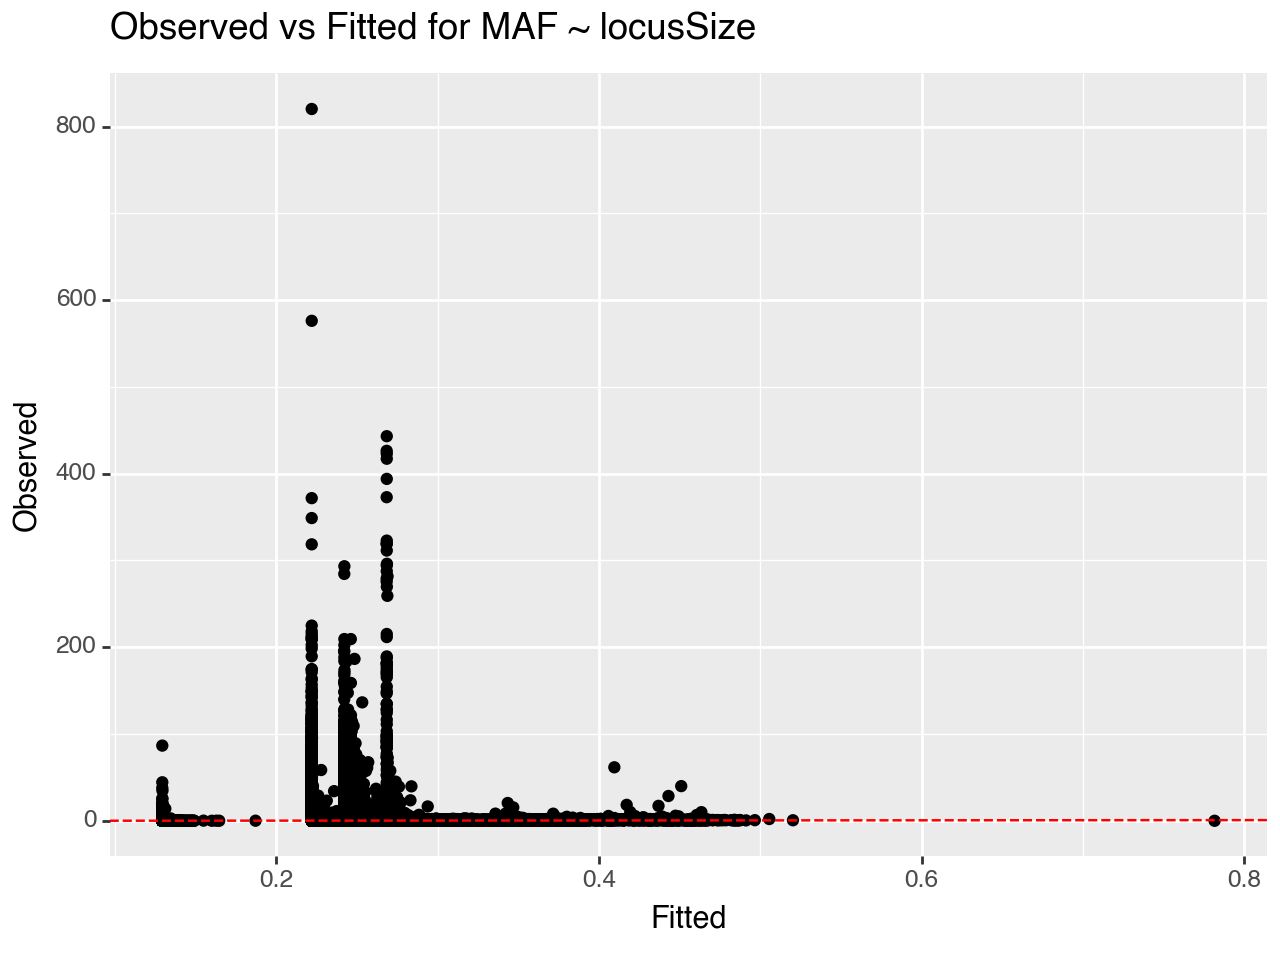

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable: MAF         
No. Observations:   2820468  Method:             REML        
No. Groups:         7        Scale:              0.0216      
Min. group size:    15933    Log-Likelihood:     1403921.3704
Max. group size:    1348868  Converged:          Yes         
Mean group size:    402924.0                                 
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         0.238    0.056    4.276 0.000  0.129  0.347
absEstimatedBeta -0.011    0.000 -429.025 0.000 -0.012 -0.011
Group Var         0.022                                      



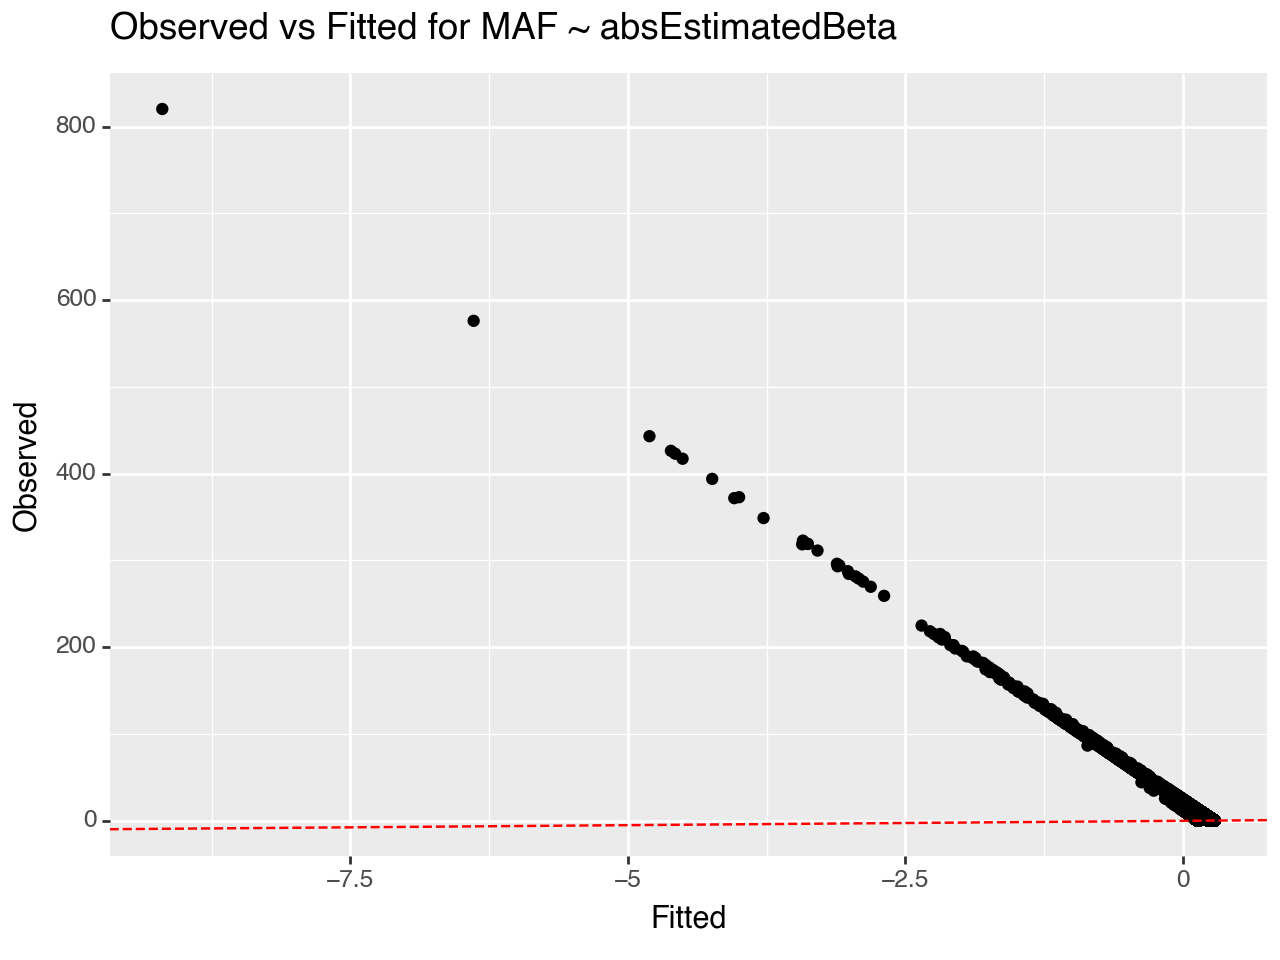

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: MAF         
No. Observations: 2820468  Method:             REML        
No. Groups:       7        Scale:              0.0230      
Min. group size:  15933    Log-Likelihood:     1315205.3044
Max. group size:  1348868  Converged:          Yes         
Mean group size:  402924.0                                 
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.227     0.057   3.949  0.000   0.114   0.339
nSamples      0.000     0.000  29.927  0.000   0.000   0.000
Group Var     0.023                                         



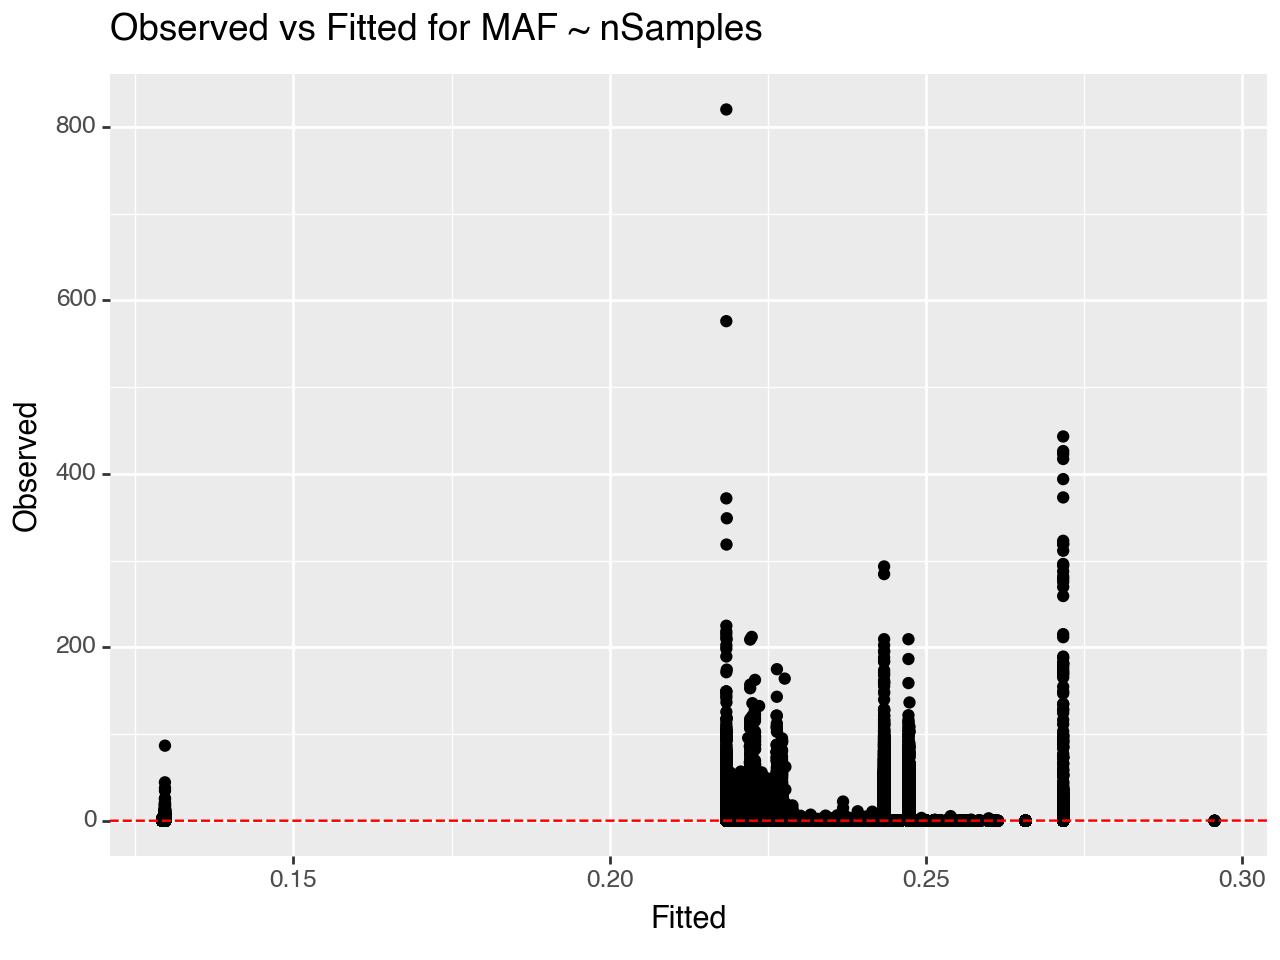

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable: locusSize     
No. Observations:   2820468  Method:             REML          
No. Groups:         7        Scale:              7537.2143     
Min. group size:    15933    Log-Likelihood:     -16592126.3897
Max. group size:    1348868  Converged:          Yes           
Mean group size:    402924.0                                   
---------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept          26.238   32.814   0.800 0.424 -38.077 90.553
absEstimatedBeta   -0.704    0.016 -44.541 0.000  -0.735 -0.673
Group Var        7537.214                                      



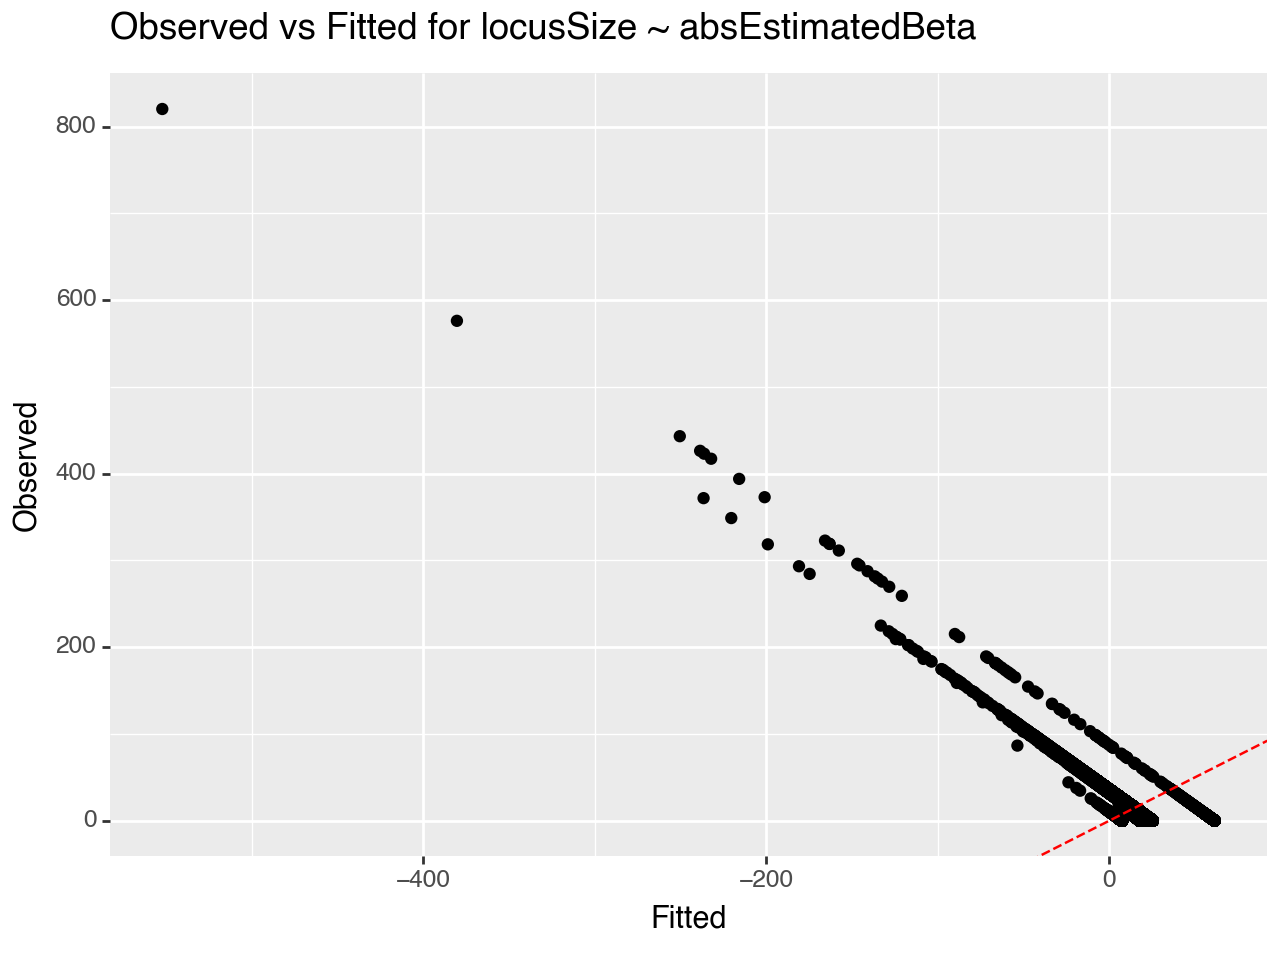

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: locusSize     
No. Observations: 2820468  Method:             REML          
No. Groups:       7        Scale:              7541.9176     
Min. group size:  15933    Log-Likelihood:     -16593017.1004
Max. group size:  1348868  Converged:          Yes           
Mean group size:  402924.0                                   
--------------------------------------------------------------
             Coef.    Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept     25.369    32.824   0.773  0.440  -38.966  89.704
nSamples       0.000     0.000  14.959  0.000    0.000   0.000
Group Var   7541.918                                          



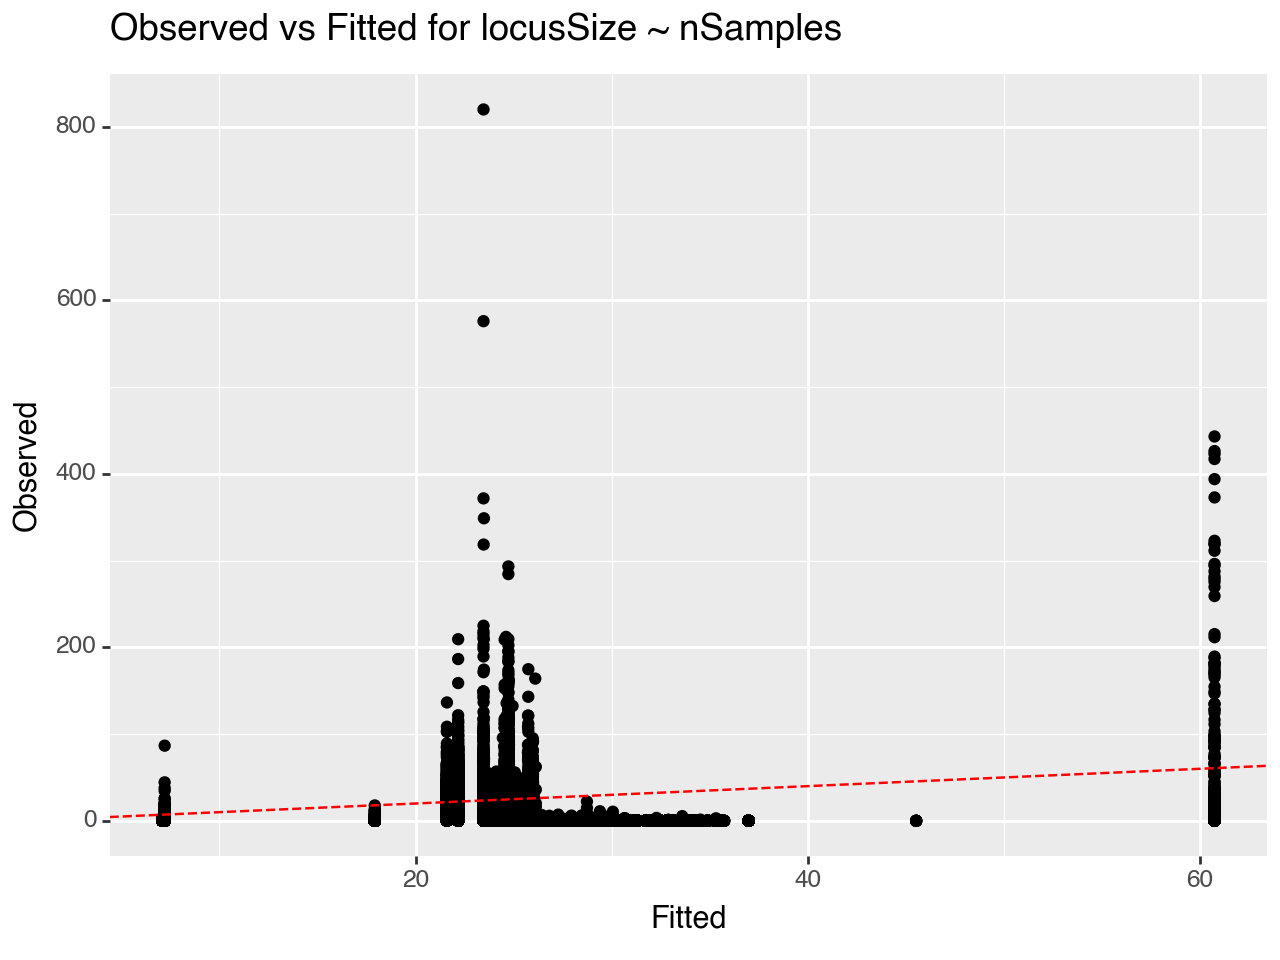

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



             Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: absEstimatedBeta
No. Observations: 2820468  Method:             REML            
No. Groups:       7        Scale:              10.6940         
Min. group size:  15933    Log-Likelihood:     -7343938.0611   
Max. group size:  1348868  Converged:          Yes             
Mean group size:  402924.0                                     
-----------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept    0.907      1.236     0.734   0.463   -1.515    3.330
nSamples    -0.000      0.000   -10.764   0.000   -0.000   -0.000
Group Var   10.694                                               



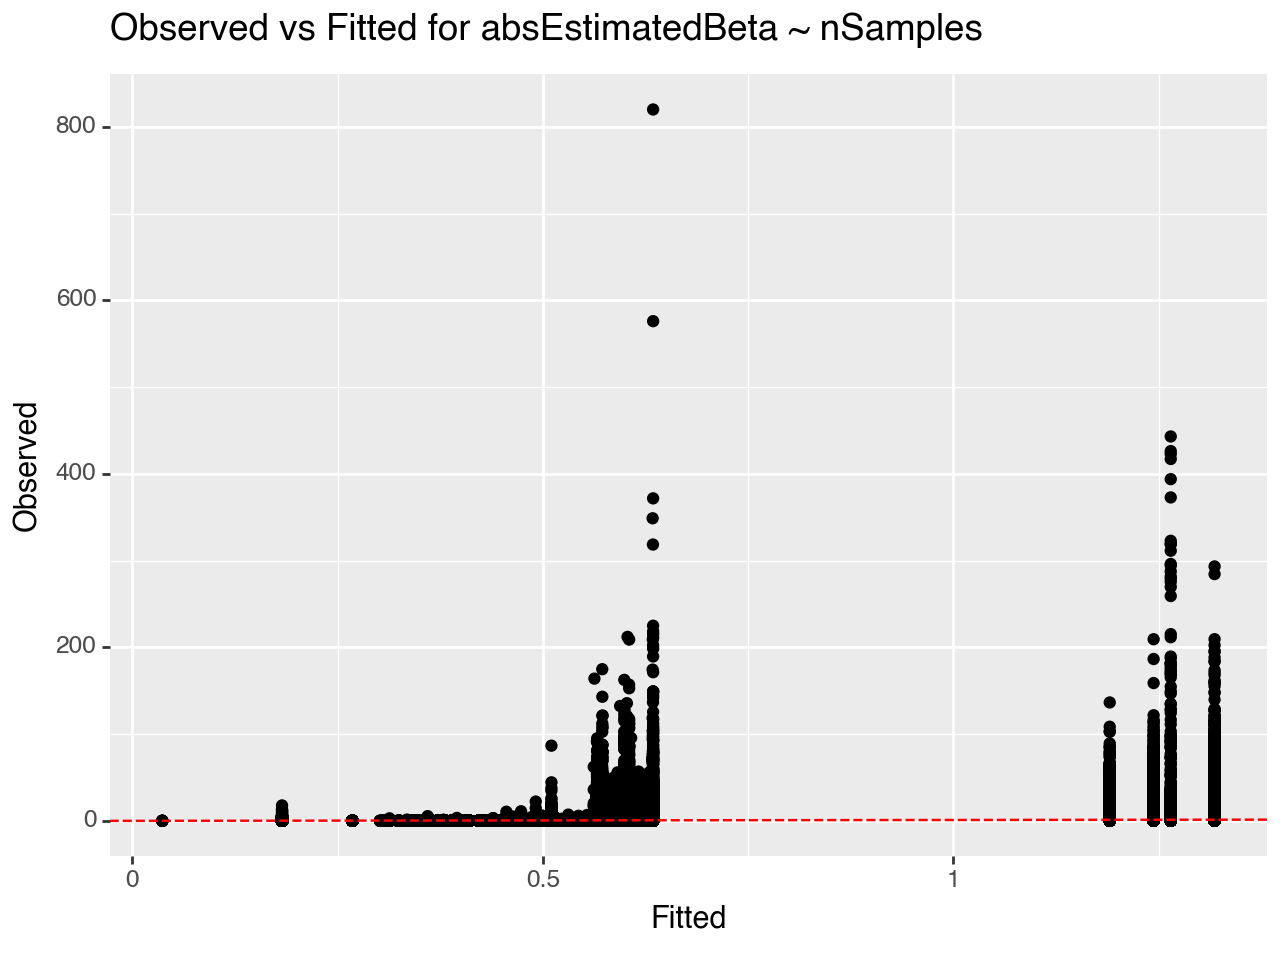

In [29]:
for formula in formulas:
    model = mixedlm(formula, clean_data, groups=clean_data["studyType"])
    result = model.fit()
    print(result.summary())
    clean_data[formula] = result.fittedvalues

    # Plotting observed vs fitted values
    plot = (
        p9.ggplot(clean_data, p9.aes(x=formula, y="absEstimatedBeta"))
        + p9.geom_point()
        + p9.geom_abline(slope=1, intercept=0, linetype="dashed", color="red")
        + p9.labs(title=f"Observed vs Fitted for {formula}", x="Fitted", y="Observed")
    )
    print(plot)  # Display the plot
